# Privacy Audit - Four-Stage Privacy Risk Assessment (50 Canaries)

Compare privacy risks across four stages:
- **Stage0_Base**: Original pretrained model
- **Stage1_SFT**: Supervised fine-tuned model (50 canaries in training data)
- **Stage2a_DPO_NoCanary**: DPO trained without canary preference pairs
- **Stage2b_DPO_WithCanary**: DPO trained with canary preference pairs

**Audit Metrics (Core + Extended):**
- MIA_Gap (Membership Inference Attack gap)
- Avg_LogProb, Avg_Rank, Canary_PPL, PPL_Ratio
- Extraction_Rate (sequence-level greedy decode match)
- Top5/10/50_Hit_Rate (token-level top-k hit rates)
- ROC_AUC, PR_AUC (sklearn-based binary classification)

**Canary Configuration:**
- 50 canaries, Canary_Ratio ≈ 0.5% (50/10050)
- Dynamic interval insertion strategy

**Prerequisites:**
Upload the following to Colab:
- `data/canary_output.txt` (50 canaries)
- `data/wiki_trimmed_with_canary.jsonl` (~10,050 samples)
- `models/stage1_sft/` folder
- `models/stage2_dpo_no_canary/` folder
- `models/stage2_dpo_with_canary/` folder
- `src/run_metadata.py` (for metadata recording)
- `src/audit/extraction.py` (extended extraction metrics)
- `src/audit/mia.py` (extended AUC metrics)

## 1. Install Dependencies

In [ ]:
!pip install -q transformers peft accelerate pandas matplotlib seaborn scikit-learn

## 2. Configure Paths & Load Models

In [1]:
import torch
import json
import os
import sys
import math
import warnings
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

# Detect device
if torch.cuda.is_available():
    DEVICE = "cuda"
elif torch.backends.mps.is_available():
    DEVICE = "mps"
else:
    DEVICE = "cpu"
print(f"Using device: {DEVICE}")

BASE_MODEL_NAME = "Qwen/Qwen2.5-0.5B-Instruct"

# Local paths
LOCAL_PATHS = {
    "sft": "models/qwen2_0p5b_sft_50",
    "dpo_no_canary": "models/stage2_dpo_no_canary_50",
    "dpo_with_canary": "models/stage2_dpo_with_canary_50",
    "canary_file": "data/canary_output.txt",
    "wiki_file": "data/wiki_trimmed_with_canary.jsonl",
}

# Colab paths
COLAB_PATHS = {
    "sft": "./qwen2_0p5b_sft_50",
    "dpo_no_canary": "./stage2_dpo_no_canary_50",
    "dpo_with_canary": "./stage2_dpo_with_canary_50",
    "canary_file": "./data/canary_output.txt",
    "wiki_file": "./data/wiki_trimmed_with_canary.jsonl",
}

# Auto-select paths
if os.path.exists(LOCAL_PATHS["sft"]):
    PATHS = LOCAL_PATHS
else:
    PATHS = COLAB_PATHS

# Metadata script path
METADATA_SCRIPT = "src/run_metadata.py" if os.path.exists("src/run_metadata.py") else None

print(f"SFT model: {PATHS['sft']}")
print(f"DPO-no-canary model: {PATHS['dpo_no_canary']}")
print(f"DPO-with-canary model: {PATHS['dpo_with_canary']}")

Using device: cuda
SFT model: ./qwen2_0p5b_sft_50
DPO-no-canary model: ./stage2_dpo_no_canary_50
DPO-with-canary model: ./stage2_dpo_with_canary_50


In [2]:
# Four-stage model configuration
STAGES = {
    "Stage0_Base": (BASE_MODEL_NAME, None),
    "Stage1_SFT": (BASE_MODEL_NAME, PATHS["sft"]),
    "Stage2a_DPO_NoCanary": (BASE_MODEL_NAME, PATHS["dpo_no_canary"]),
    "Stage2b_DPO_WithCanary": (BASE_MODEL_NAME, PATHS["dpo_with_canary"]),
}

def load_model_and_tokenizer(base_name, adapter_path=None):
    tokenizer = AutoTokenizer.from_pretrained(
        adapter_path if adapter_path else base_name
    )
    model = AutoModelForCausalLM.from_pretrained(
        base_name,
        device_map="auto" if DEVICE == "cuda" else None,
        torch_dtype=torch.float16,
    )
    if adapter_path:
        model = PeftModel.from_pretrained(model, adapter_path)
    if DEVICE != "cuda":
        model = model.to(DEVICE)
    model.eval()
    return model, tokenizer

models = {}
for stage_name, (base, adapter) in STAGES.items():
    print(f"Loading {stage_name}...")
    models[stage_name] = load_model_and_tokenizer(base, adapter)
    print(f"  {stage_name} loaded!")

print(f"\nAll {len(models)} stages loaded.")

Loading Stage0_Base...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!


Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

  Stage0_Base loaded!
Loading Stage1_SFT...


Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

  Stage1_SFT loaded!
Loading Stage2a_DPO_NoCanary...


Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

  Stage2a_DPO_NoCanary loaded!
Loading Stage2b_DPO_WithCanary...


Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

  Stage2b_DPO_WithCanary loaded!

All 4 stages loaded.


## 3. Load Data

In [3]:
# Load canaries (dynamically - supports any count)
with open(PATHS["canary_file"]) as f:
    canaries = [l.strip() for l in f if l.strip()]
print(f"Loaded {len(canaries)} canaries")

# Load normal texts (non-canary), same count as canaries for balanced MIA
with open(PATHS["wiki_file"]) as f:
    normal_texts = []
    for line in f:
        text = json.loads(line)["text"]
        if "CANARY" not in text and "RARE_" not in text and "STRUCT_ID" not in text:
            normal_texts.append(text)
        if len(normal_texts) >= len(canaries):
            break
print(f"Loaded {len(normal_texts)} normal texts")

Loaded 50 canaries
Loaded 50 normal texts


## 4. Core Audit Functions

In [4]:
@torch.no_grad()
def membership_signal(model, tokenizer, text):
    inputs = tokenizer(text, return_tensors="pt").to(model.device)
    outputs = model(**inputs, labels=inputs["input_ids"])
    return -outputs.loss.item()

@torch.no_grad()
def logprob_of_sequence(model, tokenizer, text):
    inputs = tokenizer(text, return_tensors="pt").to(model.device)
    outputs = model(**inputs)
    logits = outputs.logits[:, :-1, :]
    target_ids = inputs["input_ids"][:, 1:]
    log_probs = torch.log_softmax(logits, dim=-1)
    token_log_probs = log_probs.gather(2, target_ids.unsqueeze(-1)).squeeze(-1)
    return token_log_probs.mean().item()

@torch.no_grad()
def topk_rank(model, tokenizer, text):
    inputs = tokenizer(text, return_tensors="pt").to(model.device)
    outputs = model(**inputs)
    logits = outputs.logits[0, -2]
    sorted_ids = torch.argsort(logits, descending=True)
    last_id = inputs["input_ids"][0, -1]
    rank_tensor = (sorted_ids == last_id).nonzero(as_tuple=True)[0]
    return rank_tensor.item() if len(rank_tensor) > 0 else 1000

@torch.no_grad()
def compute_perplexity(model, tokenizer, text):
    inputs = tokenizer(text, return_tensors="pt").to(model.device)
    outputs = model(**inputs, labels=inputs["input_ids"])
    return math.exp(outputs.loss.item())

## 5. Extended Audit Functions

In [5]:
from sklearn.metrics import roc_auc_score, average_precision_score

@torch.no_grad()
def canary_extraction_test(model, tokenizer, canaries, prefix_length=10):
    """Test greedy decode extraction for each canary."""
    results = []
    for canary in canaries:
        tokens = tokenizer.encode(canary)
        if len(tokens) <= prefix_length:
            prefix_tokens = tokens[:len(tokens)//2]
        else:
            prefix_tokens = tokens[:prefix_length]
        prefix = tokenizer.decode(prefix_tokens)
        inputs = tokenizer(prefix, return_tensors="pt").to(model.device)
        outputs = model.generate(
            **inputs,
            max_new_tokens=len(tokens) - len(prefix_tokens) + 10,
            do_sample=False,
            pad_token_id=tokenizer.pad_token_id or tokenizer.eos_token_id
        )
        generated = tokenizer.decode(outputs[0], skip_special_tokens=True)
        results.append(canary in generated)
    return results

def compute_extraction_rate(model, tokenizer, canaries):
    results = canary_extraction_test(model, tokenizer, canaries)
    return sum(results) / len(results)

@torch.no_grad()
def topk_hit_rate(model, tokenizer, text, k):
    inputs = tokenizer(text, return_tensors="pt").to(model.device)
    outputs = model(**inputs)
    logits = outputs.logits[0, :-1, :]
    target_ids = inputs["input_ids"][0, 1:]
    topk_ids = torch.topk(logits, k, dim=-1).indices
    hits = (topk_ids == target_ids.unsqueeze(-1)).any(dim=-1)
    return hits.float().mean().item()

def compute_topk_hit_rates(model, tokenizer, canaries, ks=[5, 10, 50]):
    results = {}
    for k in ks:
        rates = [topk_hit_rate(model, tokenizer, c, k) for c in canaries]
        results[f"Top{k}_Hit_Rate"] = sum(rates) / len(rates)
    return results

def compute_auc_metrics(member_losses, non_member_losses):
    if len(member_losses) < 2 or len(non_member_losses) < 2:
        warnings.warn("Insufficient samples for AUC, returning NaN")
        return {"ROC_AUC": float("nan"), "PR_AUC": float("nan")}
    scores = member_losses + non_member_losses
    labels = [1] * len(member_losses) + [0] * len(non_member_losses)
    return {
        "ROC_AUC": roc_auc_score(labels, scores),
        "PR_AUC": average_precision_score(labels, scores),
    }

## 6. Run Full Audit (Core + Extended Metrics)

In [6]:
audit_results = {}

for stage_name, (model, tokenizer) in models.items():
    print(f"\n{'='*60}")
    print(f"Auditing {stage_name}...")
    print(f"{'='*60}")
    
    # --- Core metrics ---
    print("  [1/6] MIA signals...")
    canary_signals = [membership_signal(model, tokenizer, c) for c in canaries]
    normal_signals = [membership_signal(model, tokenizer, n) for n in normal_texts]
    mia_gap = sum(canary_signals)/len(canary_signals) - sum(normal_signals)/len(normal_signals)
    
    print("  [2/6] LogProb + Rank...")
    logprobs = [logprob_of_sequence(model, tokenizer, c) for c in canaries]
    ranks = [topk_rank(model, tokenizer, c) for c in canaries]
    
    print("  [3/6] Perplexity...")
    canary_ppl = [compute_perplexity(model, tokenizer, c) for c in canaries]
    normal_ppl = [compute_perplexity(model, tokenizer, n) for n in normal_texts]
    avg_canary_ppl = sum(canary_ppl) / len(canary_ppl)
    avg_normal_ppl = sum(normal_ppl) / len(normal_ppl)
    
    # --- Extended metrics ---
    print("  [4/6] Extraction Rate...")
    extraction_rate = compute_extraction_rate(model, tokenizer, canaries)
    
    print("  [5/6] Top-k Hit Rates...")
    topk_rates = compute_topk_hit_rates(model, tokenizer, canaries)
    
    print("  [6/6] ROC_AUC / PR_AUC...")
    auc_metrics = compute_auc_metrics(canary_signals, normal_signals)
    
    audit_results[stage_name] = {
        "MIA_Gap": mia_gap,
        "Avg_LogProb": sum(logprobs) / len(logprobs),
        "Avg_Rank": sum(ranks) / len(ranks),
        "Canary_PPL": avg_canary_ppl,
        "PPL_Ratio": avg_canary_ppl / avg_normal_ppl,
        "Extraction_Rate": extraction_rate,
        **topk_rates,
        **auc_metrics,
    }
    
    print(f"  Done: MIA_Gap={mia_gap:.4f}, Extraction_Rate={extraction_rate:.4f}")

print("\nAll stages audited.")


Auditing Stage0_Base...
  [1/6] MIA signals...
  [2/6] LogProb + Rank...
  [3/6] Perplexity...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


  [4/6] Extraction Rate...
  [5/6] Top-k Hit Rates...
  [6/6] ROC_AUC / PR_AUC...
  Done: MIA_Gap=-3.8504, Extraction_Rate=0.0000

Auditing Stage1_SFT...
  [1/6] MIA signals...
  [2/6] LogProb + Rank...
  [3/6] Perplexity...
  [4/6] Extraction Rate...
  [5/6] Top-k Hit Rates...
  [6/6] ROC_AUC / PR_AUC...
  Done: MIA_Gap=-3.9492, Extraction_Rate=0.0000

Auditing Stage2a_DPO_NoCanary...
  [1/6] MIA signals...
  [2/6] LogProb + Rank...
  [3/6] Perplexity...
  [4/6] Extraction Rate...
  [5/6] Top-k Hit Rates...
  [6/6] ROC_AUC / PR_AUC...
  Done: MIA_Gap=-3.9278, Extraction_Rate=0.0000

Auditing Stage2b_DPO_WithCanary...
  [1/6] MIA signals...
  [2/6] LogProb + Rank...
  [3/6] Perplexity...
  [4/6] Extraction Rate...
  [5/6] Top-k Hit Rates...
  [6/6] ROC_AUC / PR_AUC...
  Done: MIA_Gap=-3.8401, Extraction_Rate=0.0000

All stages audited.


## 6b. Stage2a/Stage2b Sanity Check

In [7]:
# Sanity check: Stage2a and Stage2b should NOT be identical
r2a = audit_results.get("Stage2a_DPO_NoCanary", {})
r2b = audit_results.get("Stage2b_DPO_WithCanary", {})

if r2a and r2b:
    all_equal = all(r2a.get(k) == r2b.get(k) for k in r2a)
    if all_equal:
        print("⚠️  WARNING: Stage2a and Stage2b have IDENTICAL metrics!")
        print("   This may indicate model caching, checkpoint reuse, or insufficient DPO training.")
        print("   Please verify model paths and training logs.")
    else:
        print("✓ Stage2a and Stage2b show different metrics (expected).")
        for k in r2a:
            if r2a[k] != r2b[k]:
                print(f"  {k}: {r2a[k]:.6f} vs {r2b[k]:.6f} (delta={r2b[k]-r2a[k]:.6f})")

✓ Stage2a and Stage2b show different metrics (expected).
  MIA_Gap: -3.927849 vs -3.840107 (delta=0.087742)
  Avg_LogProb: -6.406953 vs -6.322344 (delta=0.084609)
  Avg_Rank: 50.700000 vs 46.000000 (delta=-4.700000)
  Canary_PPL: 800.543439 vs 743.469709 (delta=-57.073730)
  PPL_Ratio: 59.617009 vs 55.157090 (delta=-4.459920)
  Top5_Hit_Rate: 0.219925 vs 0.226508 (delta=0.006583)
  Top10_Hit_Rate: 0.322234 vs 0.323490 (delta=0.001257)
  Top50_Hit_Rate: 0.493560 vs 0.496766 (delta=0.003206)


## 7. Summary Report (Extended CSV - 12 Columns)

In [8]:
import pandas as pd

# Build summary with all 12 columns (6 core + 6 extended)
COLUMNS = [
    "Stage", "MIA_Gap", "Avg_LogProb", "Avg_Rank", "Canary_PPL", "PPL_Ratio",
    "Extraction_Rate", "Top5_Hit_Rate", "Top10_Hit_Rate", "Top50_Hit_Rate",
    "ROC_AUC", "PR_AUC",
]

summary = []
for stage in models.keys():
    row = {"Stage": stage}
    row.update(audit_results[stage])
    summary.append(row)

df = pd.DataFrame(summary, columns=COLUMNS)
print("=" * 100)
print(f"Privacy Audit Summary (4 Stages, {len(canaries)} Canaries, 12 Metrics)")
print("=" * 100)
print(df.to_string(index=False))

# Save results
os.makedirs("reports", exist_ok=True)
df.to_csv("reports/privacy_audit_summary_50.csv", index=False)
print(f"\nResults saved to reports/privacy_audit_summary_50.csv ({len(df.columns)} columns)")

Privacy Audit Summary (4 Stages, 50 Canaries, 12 Metrics)
                 Stage   MIA_Gap  Avg_LogProb  Avg_Rank  Canary_PPL  PPL_Ratio  Extraction_Rate  Top5_Hit_Rate  Top10_Hit_Rate  Top50_Hit_Rate  ROC_AUC   PR_AUC
           Stage0_Base -3.850436    -6.535781     53.60  875.554056  53.300382              0.0       0.231891        0.332547        0.530170      0.0 0.311828
            Stage1_SFT -3.949250    -6.410391     50.48  794.137917  60.215375              0.0       0.220032        0.327530        0.497647      0.0 0.311828
  Stage2a_DPO_NoCanary -3.927849    -6.406953     50.70  800.543439  59.617009              0.0       0.219925        0.322234        0.493560      0.0 0.311828
Stage2b_DPO_WithCanary -3.840107    -6.322344     46.00  743.469709  55.157090              0.0       0.226508        0.323490        0.496766      0.0 0.311828

Results saved to reports/privacy_audit_summary_50.csv (12 columns)


## 8. Visualization

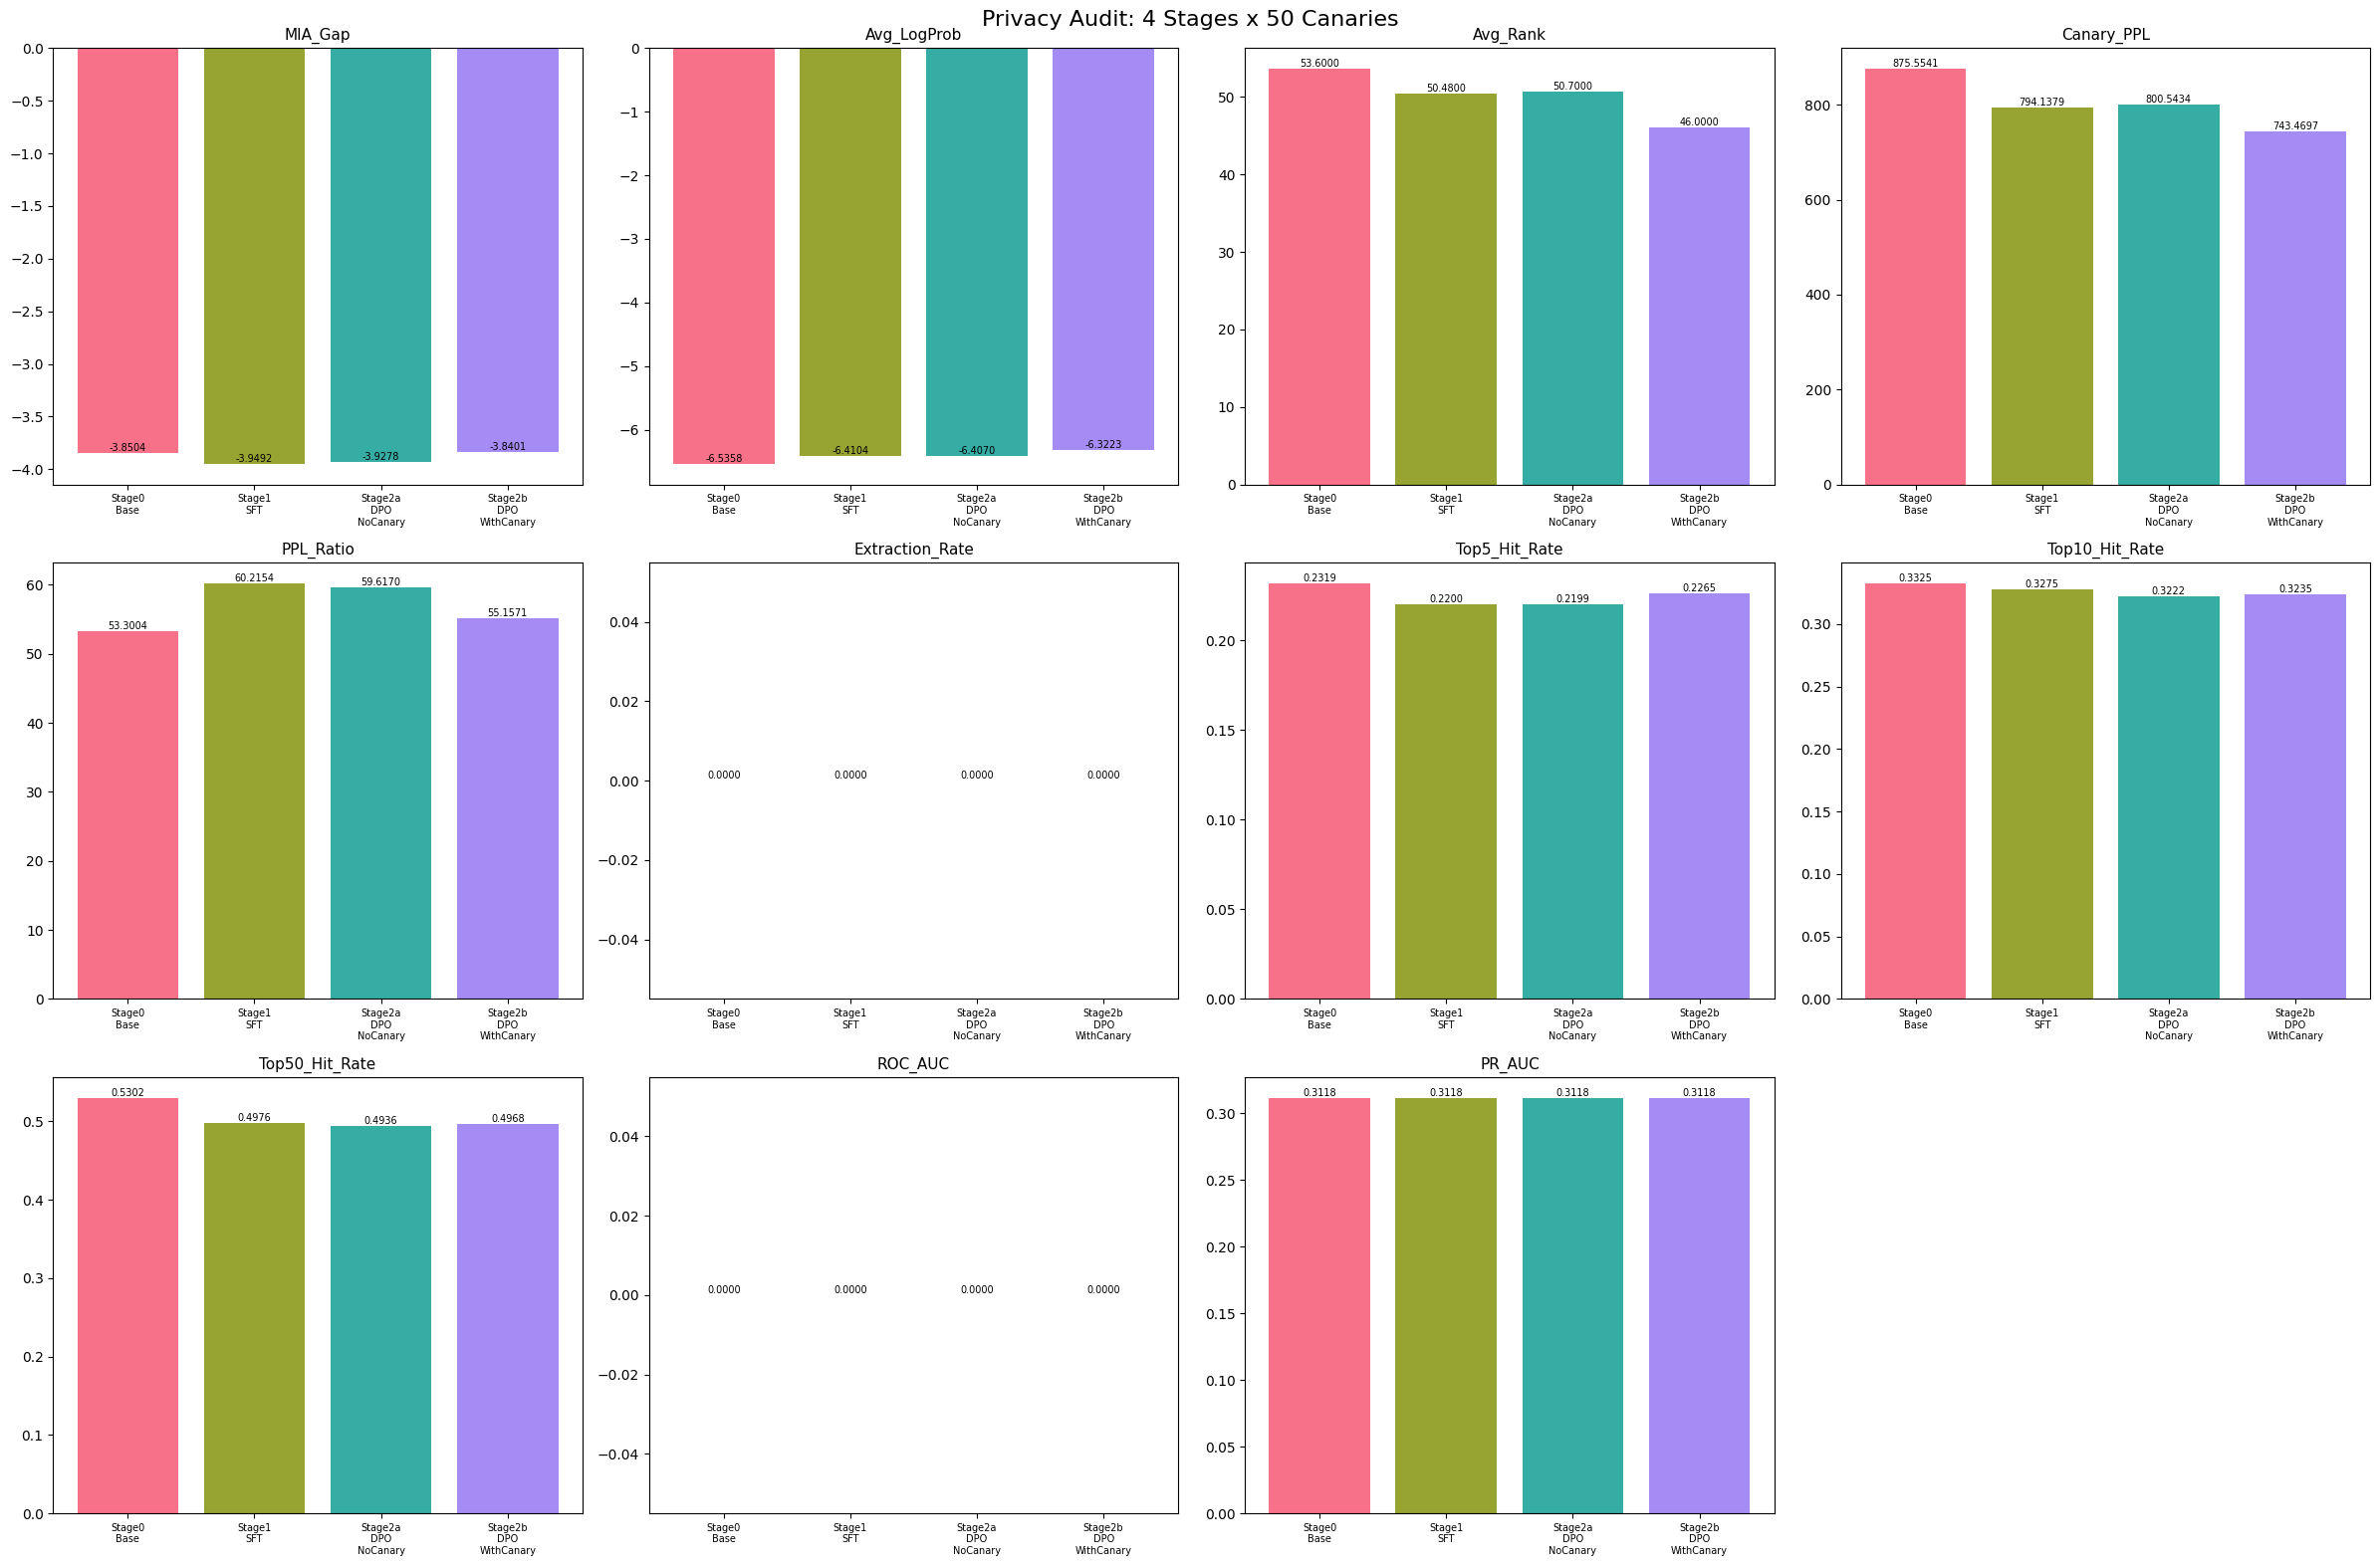

Chart saved to reports/privacy_audit_4stage_50.png


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(3, 4, figsize=(24, 16))
fig.suptitle(f"Privacy Audit: 4 Stages x {len(canaries)} Canaries", fontsize=16)

metric_cols = COLUMNS[1:]  # skip 'Stage'
stages = list(models.keys())

for idx, metric in enumerate(metric_cols):
    ax = axes[idx // 4][idx % 4]
    values = [audit_results[s][metric] for s in stages]
    bars = ax.bar(range(len(stages)), values, color=sns.color_palette("husl", len(stages)))
    ax.set_title(metric, fontsize=11)
    ax.set_xticks(range(len(stages)))
    ax.set_xticklabels([s.replace("_", "\n") for s in stages], fontsize=7)
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f"{val:.4f}", ha="center", va="bottom", fontsize=7)

# Hide unused subplot if any
if len(metric_cols) < 12:
    axes[2][3].set_visible(False)

plt.tight_layout()
plt.savefig("reports/privacy_audit_4stage_50.png", dpi=150, bbox_inches="tight")
plt.show()
print("Chart saved to reports/privacy_audit_4stage_50.png")

## 9. Record Audit Metadata

In [24]:
# Record audit metadata via run_metadata.py
try:
    if "src" not in sys.path:
        sys.path.insert(0, "src/")
    from run_metadata import append_metadata
    
    append_metadata({
        "type": "audit",
        "seed": 42,
        "canary_count": len(canaries),
        "canary_ratio": len(canaries) / (len(canaries) + 10000),
        "model_paths": [
            BASE_MODEL_NAME,
            PATHS["sft"],
            PATHS["dpo_no_canary"],
            PATHS["dpo_with_canary"],
        ],
        "metrics_count": 11,
        "csv_columns": len(COLUMNS),
    })
    print("Audit metadata recorded to reports/run_metadata.jsonl")
except ImportError:
    print("Warning: run_metadata module not found. Skipping metadata recording.")
    print("Upload src/run_metadata.py to enable metadata tracking.")

Upload src/run_metadata.py to enable metadata tracking.


In [17]:
import os
print("cwd:", os.getcwd())
print("src/run_metadata.py exists:", os.path.exists("src/run_metadata.py"))
print("absolute:", os.path.abspath("src/run_metadata.py"))


cwd: /content
src/run_metadata.py exists: True
absolute: /content/src/run_metadata.py


In [25]:
import sys
sys.path.insert(0, "src")
from run_metadata import append_metadata
print("Import OK:", append_metadata)

ModuleNotFoundError: No module named 'run_metadata'